In [1]:
# ensuring we are using tensorflow 1.x (stable)
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# mounting google drive   
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# checking GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
# importing dependencies
import os, sys
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


In [10]:
# some constants

IMAGE_SIZE = 128
NUM_CLASSES = 12

DATASET_FINAL_PATH = "/content/drive/Shareddrives/DLNN_ProjF/data/unaugmented_final_data"
NUMBER_BATCHES = 1
NUMBER_PREDS = 100 #keeping this voer 100 sometimes causes colab runtime to crash

MODEL_PATH = "/content/drive/Shareddrives/DLNN_ProjF/data/model/SHM_3_unaugmented_data_best.h5"

CLASS_NUMBERS = {
    "left_wrist" : 0,
    "left_elbow" : 1,
    "left_shoulder" : 2,
    "left_hip" : 3,
    "left_knee" : 4,
    "left_ankle" : 5,
    "right_wrist" : 6,
    "right_elbow" : 7,
    "right_shoulder" : 8,
    "right_hip" : 9,
    "right_knee" : 10,
    "right_ankle" : 11    
}

In [21]:
# place holders for data
train_images = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=float)
train_heatmaps = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype=float)
train_headlengths = np.zeros(shape = (1, 1), dtype=float)

test_images = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=float)
test_heatmaps = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype=float)
test_headlengths = np.zeros(shape=(1, 1), dtype=float)
##########

# loading the data from file
for batch_number in range(NUMBER_BATCHES):
  temp_train_images = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_images.npy") )
  temp_train_heatmaps = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_heatmaps.npy"))
  temp_train_headlengths =np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_headlengths.npy"))

  temp_test_images = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_images.npy"))
  temp_test_heatmaps = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_heatmaps.npy"))
  temp_test_headlengths = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_headlengths.npy"))


  train_images = np.concatenate((train_images, temp_train_images), axis = 0)
  train_heatmaps = np.concatenate((train_heatmaps, temp_train_heatmaps), axis = 0)
  train_headlengths = np.concatenate((train_headlengths, temp_train_headlengths), axis = 0)

  test_images = np.concatenate((test_images, temp_test_images), axis = 0)
  test_heatmaps = np.concatenate((test_heatmaps, temp_test_heatmaps), axis = 0)
  test_headlengths = np.concatenate((test_headlengths, temp_test_headlengths), axis = 0)


# removing the dummy first entry from data
train_images = train_images[1:]
train_heatmaps = train_heatmaps[1:]
train_headlengths = train_headlengths[1:]

test_images = test_images[1:]
test_heatmaps = test_heatmaps[1:]
test_headlengths = test_headlengths[1:]

In [22]:
# verify if data loaded properly
print(train_images.shape, train_heatmaps.shape)


(797, 128, 128, 3) (797, 128, 128, 13)


In [23]:
from tensorflow.keras.models import load_model

SHM = load_model(os.path.join("/content/drive/Shareddrives/DLNN_ProjF/data/model", "SHM_3_unaugmented_data_best.h5"), compile = False)

(100, 128, 128, 13)
(100, 128, 128, 13)


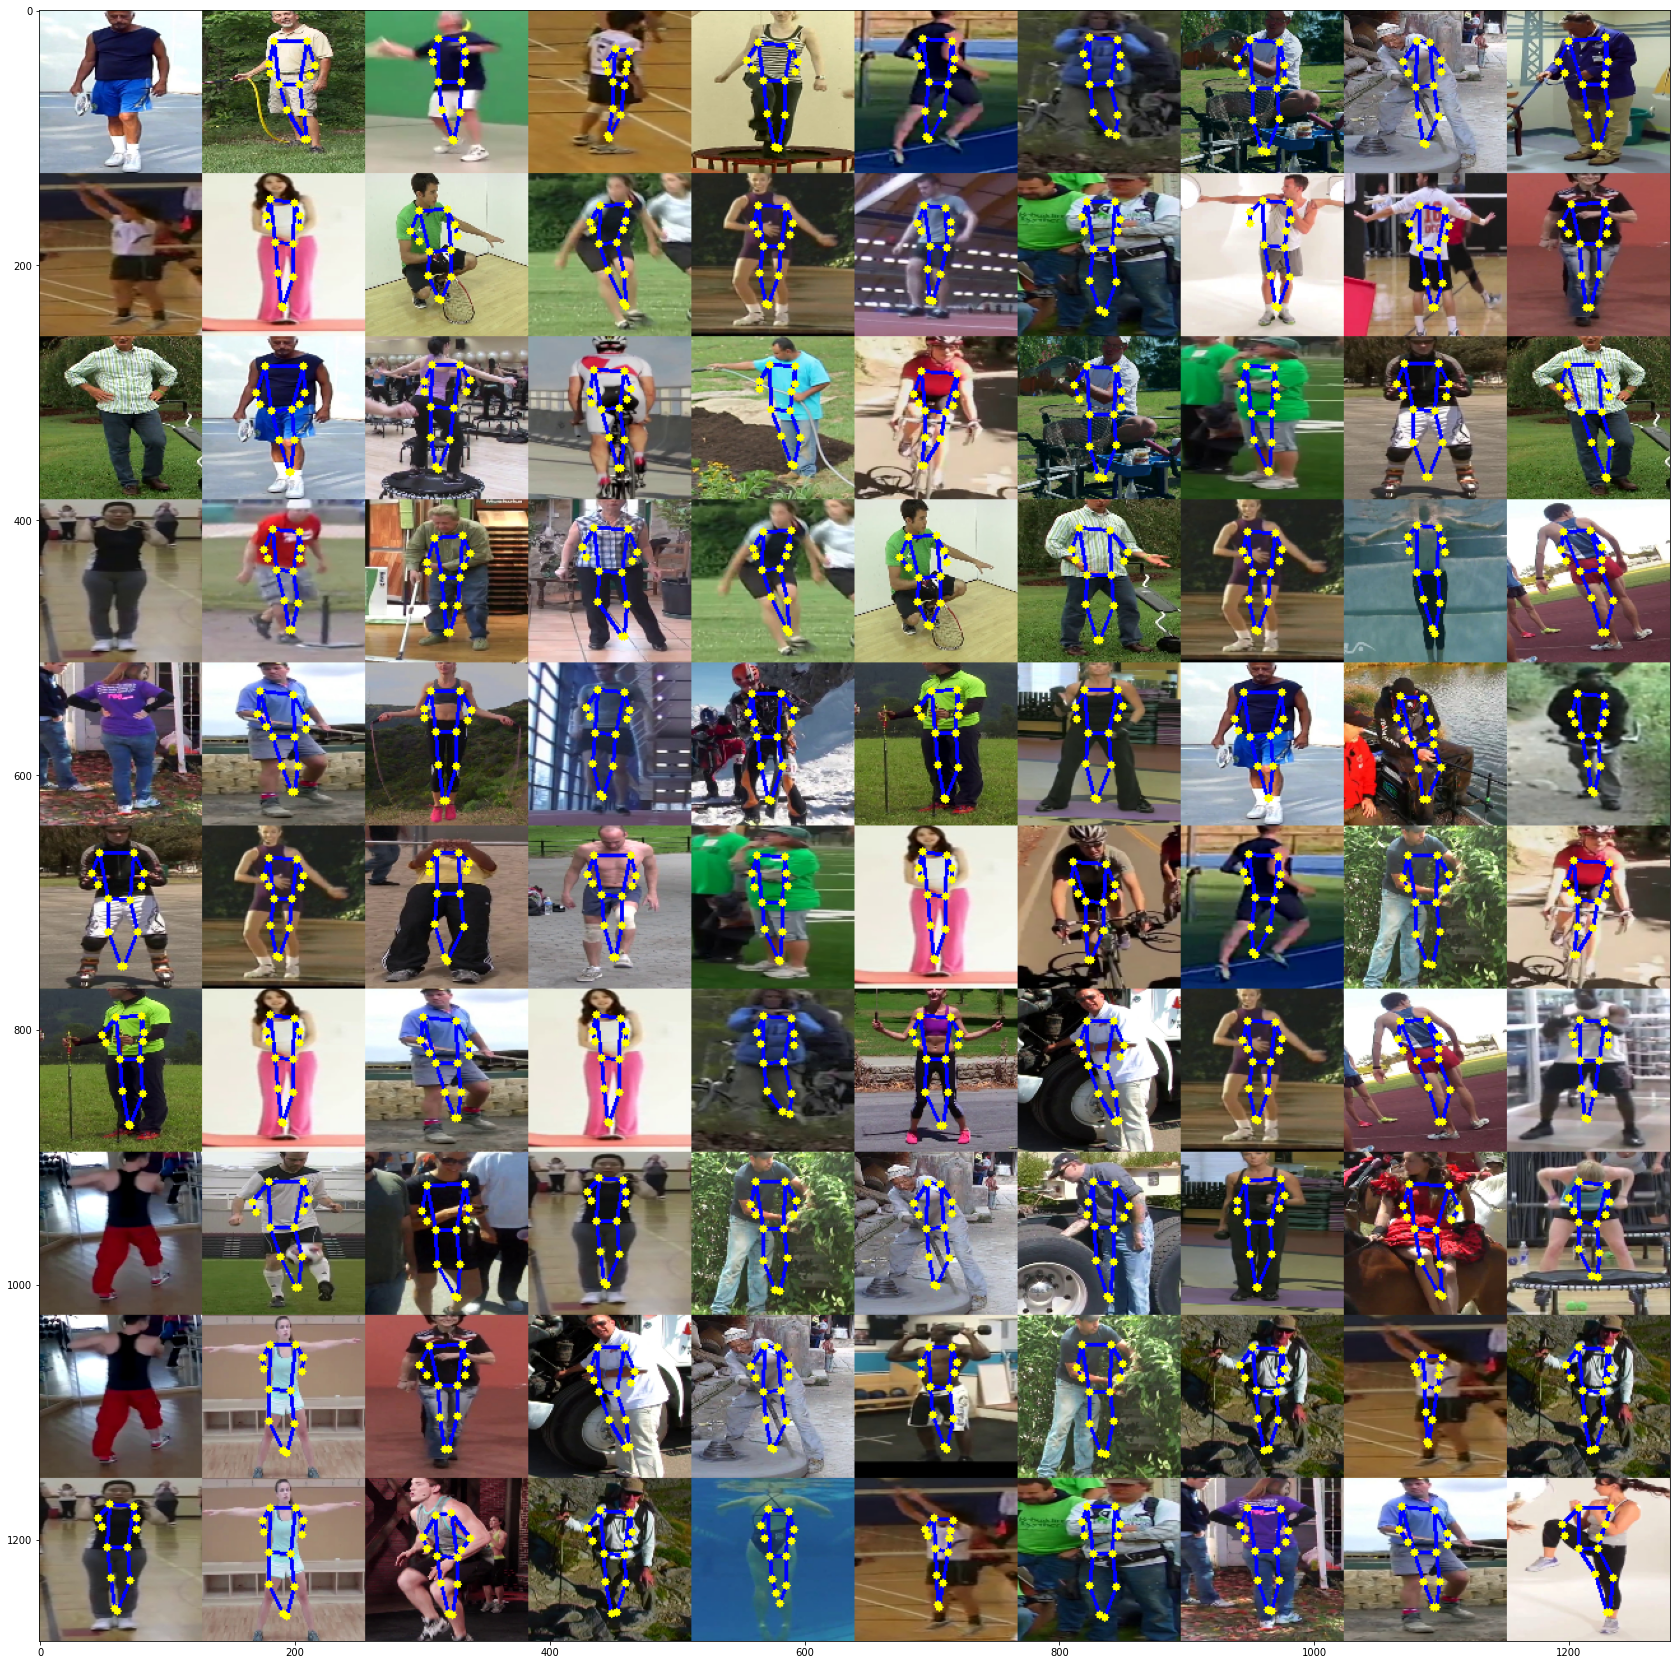

In [24]:
x = range(0, IMAGE_SIZE)
y = range(0, IMAGE_SIZE)
(X,Y) = np.meshgrid(x,y)


pred_heatmaps = SHM.predict(train_images[:NUMBER_PREDS])[-1]
gt_heatmaps = train_heatmaps[:NUMBER_PREDS]

print(pred_heatmaps.shape)
print(gt_heatmaps.shape)

imgs = train_images[:NUMBER_PREDS]


# sample images
cols = 10
rows = 10
np.random.seed(33)

row_images = []

for i in range(rows):
  indices = np.random.rand(cols)
  indices = (indices*NUMBER_PREDS).astype(np.int64)  

  row = train_images[indices[0], ...]
  for j in range(1, cols):
    temp = train_images[indices[j]]

    x_coords = []
    y_coords = []
    for channel in range(NUM_CLASSES):
      # getting GT-coords
      img = pred_heatmaps[indices[j], ..., channel]
      gt_x_coord = (X*img).sum() / img.sum().astype("float")
      gt_y_coord = (Y*img).sum() / img.sum().astype("float")

      # getting PRED-coords
      img = pred_heatmaps[indices[j], ..., channel]
      pred_x_coord = (X*img).sum() / img.sum().astype("float")
      pred_y_coord = (Y*img).sum() / img.sum().astype("float")

      x_coord = int((gt_x_coord + pred_x_coord) / 2)
      y_coord = int((gt_y_coord + pred_y_coord) / 2)

      x_coords.append(x_coord)
      y_coords.append(y_coord)
      # temp = cv2.circle(temp, (x_coord, y_coord), 3, (0, 1, 1), -1)

    temp = cv2.line(temp, (x_coords[0], y_coords[0]), (x_coords[1], y_coords[1]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[1], y_coords[1]), (x_coords[2], y_coords[2]), (1, 0, 0), 2)

    temp = cv2.line(temp, (x_coords[3], y_coords[3]), (x_coords[4], y_coords[4]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[4], y_coords[4]), (x_coords[5], y_coords[5]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[6], y_coords[6]), (x_coords[7], y_coords[7]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[7], y_coords[7]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[10], y_coords[10]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[10], y_coords[10]), (x_coords[11], y_coords[11]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[3], y_coords[3]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[2], y_coords[2]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[2], y_coords[2]), (x_coords[3], y_coords[3]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    
    for channel in range(NUM_CLASSES):
        temp = cv2.circle(temp, (x_coords[channel], y_coords[channel]), 3, (0, 1, 1), -1)

    row = np.hstack((row, train_images[indices[j]]))
  
  row_images.append(row[:])

image = row_images[0]
for i in range(1, rows):
  image = np.vstack((image, row_images[i]))


plt.figure(figsize=(cols*3, rows*3))
plt.imshow(cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_BGR2RGB))


In [42]:
def euclidean(a,b):
  return(np.sqrt(np.sum((a-b)** 2)))


x = range(0, IMAGE_SIZE)
y = range(0, IMAGE_SIZE)
(X,Y) = np.meshgrid(x,y)

trues = np.array([0 for i in range(12)])
falses = np.array([0 for i in range(12)])

for i in range(NUMBER_PREDS):
  for channel in range(NUM_CLASSES):
    # getting GT-coords
    img = gt_heatmaps[i, ..., channel]
    gt_x_coord = (X*img).sum() / img.sum().astype("float")
    gt_y_coord = (Y*img).sum() / img.sum().astype("float")

    # getting PRED-coords
    img = pred_heatmaps[i, ..., channel]
    pred_x_coord = (X*img).sum() / img.sum().astype("float")
    pred_y_coord = (Y*img).sum() / img.sum().astype("float")

    distance = euclidean(np.array([pred_x_coord, pred_y_coord]), np.array([gt_x_coord, gt_y_coord]))

    if distance < train_headlengths[i]*4:
      trues[channel] +=1
    else:
      falses[channel] +=1

In [44]:
#PCKh@0.5 part-wise
trues / (trues + falses)

array([0.64, 0.77, 0.86, 0.93, 0.92, 0.78, 0.62, 0.8 , 0.88, 0.97, 0.86,
       0.76])